# Random Forest Algorithm

In [1]:
# Here are the several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

/kaggle/input/mlbio1/sample_submission.csv
/kaggle/input/mlbio1/test.csv
/kaggle/input/mlbio1/train.csv


In [2]:
#Common Model Algorithms
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

#Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

#Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

In [3]:
#FOR Kaggle
sample = pd.read_csv('/kaggle/input/mlbio1/sample_submission.csv')
test = pd.read_csv('/kaggle/input/mlbio1/test.csv')
train = pd.read_csv('/kaggle/input/mlbio1/train.csv')

#For local
# sample = pd.read_csv('healthcare-dataset-stroke-data/sample_submission.csv')
# test = pd.read_csv('healthcare-dataset-stroke-data/test.csv')
# train = pd.read_csv('healthcare-dataset-stroke-data/train.csv')

In [4]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


# NA strategies

In [5]:
#statistics about missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
smoking_status,9176,0.305856
bmi,1017,0.033899
stroke,0,0.000000
avg_glucose_level,0,0.000000
Residence_type,0,0.000000
work_type,0,0.000000
ever_married,0,0.000000
heart_disease,0,0.000000
hypertension,0,0.000000
age,0,0.000000


In [11]:
# fill with mean
median_bmi = train['bmi'].median()
train['bmi'] = train['bmi'].fillna(median_bmi)
test['bmi'] = test['bmi'].fillna(median_bmi)

# Data visualization

In [12]:
train.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,0


# numeric variables analysis

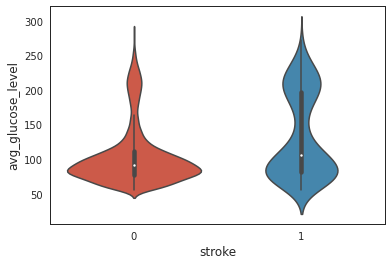

In [13]:
sns.violinplot(y='avg_glucose_level', x='stroke', scale = 'area', data = train)

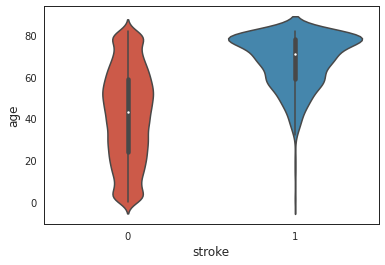

In [14]:
sns.violinplot(y='age', x='stroke', scale = 'area', data = train)

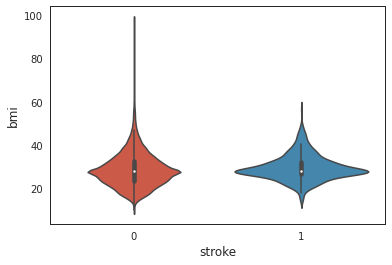

In [15]:
sns.violinplot(y='bmi', x='stroke', scale = 'area', data = train)

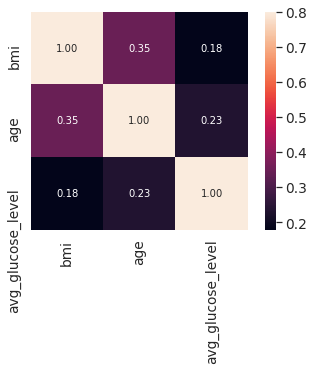

In [16]:
# correlation between numeric variables, might be used further in feature selection
numeric_variables = ['bmi', 'age', 'avg_glucose_level']
corrmat = train[numeric_variables].corr()
sns.set(font_scale=1.25)
sns.heatmap(corrmat, vmax=.8, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},)

# categorical variables analysis

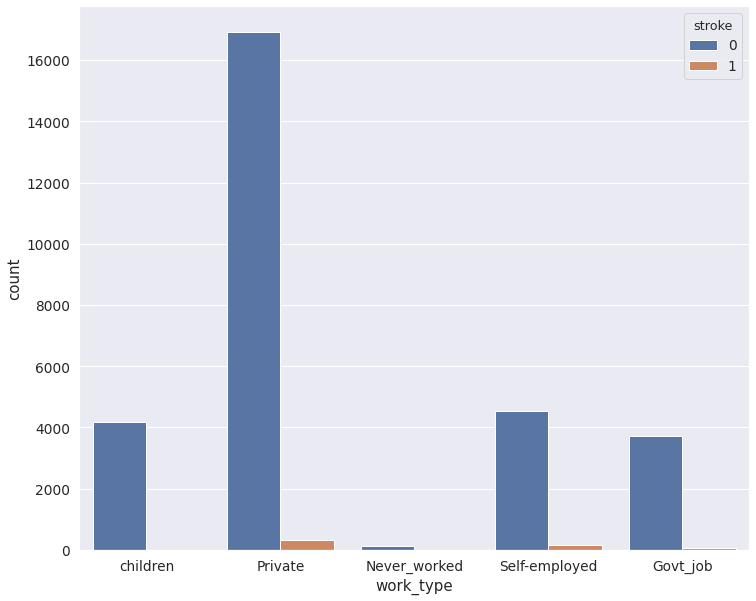

In [17]:
# multiclass variables
fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(x='work_type', hue='stroke', data=train, ax=ax)

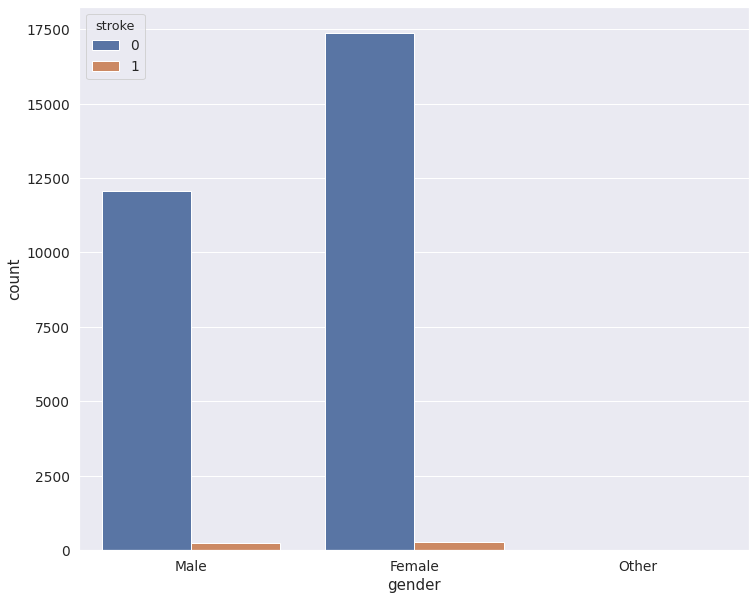

In [18]:
fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(x='gender', hue='stroke', data=train,ax=ax)

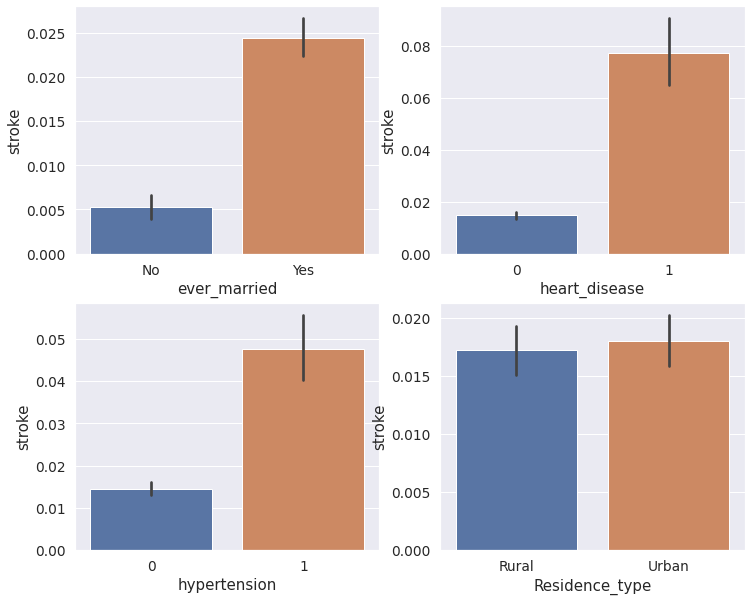

In [19]:
# binary variables
fig, ax = plt.subplots(figsize=(12, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i, binary_feature in enumerate(['ever_married', 'heart_disease', 'hypertension', 'Residence_type'], 1):
    ax = plt.subplot(2, 2, i)
    sns.barplot(x=binary_feature, y='stroke', data=train)

# Categorical variables encoding
smooth target encoding

In [20]:
# for adjusting target encoding constant of "smoothness" cross validation was used
def cross_validation_for_roc_auc(clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
        
    return scores

In [21]:
def calc_smooth_mean(train, test, by, on, m):
    # Compute the global mean
    mean = train[on].mean()

    # Compute the number of values and the mean of each group
    agg = train.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return train[by].map(smooth), test[by].map(smooth)


In [22]:
# adjusting m

for const in range(0, 21, 5):
    lgb = LGBMClassifier(n_estimators=50, max_depth=3)
    sgd = SGDClassifier(loss='log', penalty = 'elasticnet')
    train['gender_target_enc'],test['gender_target_enc'] = \
    calc_smooth_mean(train, test, by='gender',on='stroke', m=const)
    print(const, np.mean(cross_validation_for_roc_auc(lgb, train[['gender_target_enc']] , train['stroke'])),
         np.mean(cross_validation_for_roc_auc(sgd, train[['gender_target_enc']] , train['stroke'])))

0 0.5181527344280619 0.5
5 0.5181527344280619 0.5
10 0.5181527344280619 0.5
15 0.5181527344280619 0.5
20 0.5181527344280619 0.5


with every m gender_target_enc gives almost random prediction, so it was removed (checked with another model)

In [23]:
train = train.drop('gender_target_enc', 1)
test = test.drop('gender_target_enc', 1)

train = train.drop('gender', 1)
test = test.drop('gender', 1)

In [24]:
# there were only few other genders, so they were considered to be Na
train['work_type_target_enc'],test['work_type_target_enc'] = \
calc_smooth_mean(train, test, by='work_type',on='stroke', m=0)

# dummy encoding

In [25]:
# for work_type, ever_married and Residence_type one hot encoding was used
for i in train['work_type'].unique():
    train['work_type_is_{}'.format(i)] = (train['work_type'] == i)*1
    test['work_type_is_{}'.format(i)] = (test['work_type'] == i)*1
train = train.drop('work_type', 1)

In [26]:
train['ever_married'] = train['ever_married'].replace({'Yes':1, 'No':0 })
test['ever_married'] = test['ever_married'].replace({'Yes':1, 'No':0 })

train['Residence_type'] = train['Residence_type'].replace({'Urban':1, 'Rural':0 })
test['Residence_type'] = test['Residence_type'].replace({'Urban':1, 'Rural':0 })

In [27]:
train.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_target_enc,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job
0,30669,3.0,0,0,0,0,95.12,18.0,0,0.000478,1,0,0,0,0
1,30468,58.0,1,0,1,1,87.96,39.2,0,0.018118,0,1,0,0,0
2,16523,8.0,0,0,0,1,110.89,17.6,0,0.018118,0,1,0,0,0
3,56543,70.0,0,0,1,0,69.04,35.9,0,0.018118,0,1,0,0,0
4,46136,14.0,0,0,0,0,161.28,19.1,0,0.000000,0,0,1,0,0


# tSNE

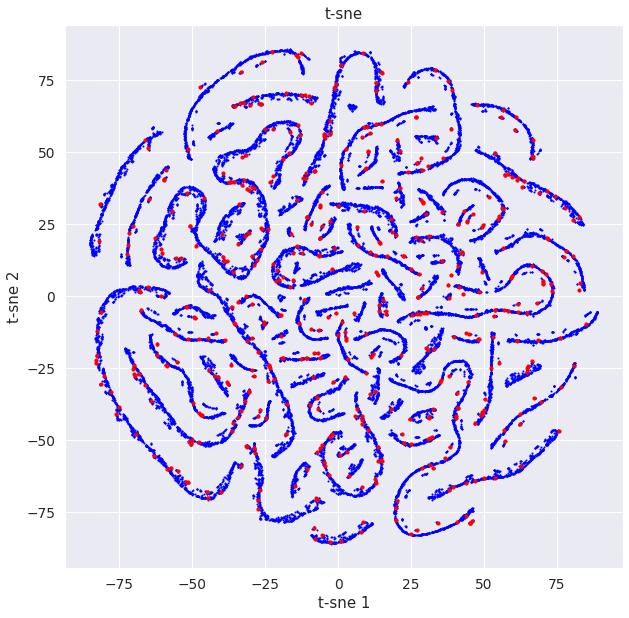

In [28]:
X_embedded = TSNE(n_components=2).fit_transform(train)
plt.figure(figsize=(10,10))

plt.scatter(X_embedded[train['stroke']==0 ,0],
             X_embedded[train['stroke']==0 ,1],  c ='#0000FF', s =1)


plt.scatter(X_embedded[train['stroke']==1 ,0],
             X_embedded[train['stroke']==1 ,1],  c ='#FF0000', s =10)
plt.xlabel('t-sne 1')
plt.ylabel('t-sne 2')
plt.title('t-sne')
plt.show()


# Features selection

In [29]:
all_features = [ 'age', 'hypertension', 'heart_disease', 'ever_married',
        'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_target_enc',
         'work_type_is_children',
       'work_type_is_Private', 'work_type_is_Never_worked',
       'work_type_is_Self-employed', 'work_type_is_Govt_job']

In [31]:
sgd = SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')
lgb = LGBMClassifier()
rndf = RandomForestClassifier()

In [32]:
# feature selection for SGD classifier model
for f in all_features:
    scores = cross_validation_for_roc_auc(sgd, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))

age 0.8366076869311634
hypertension 0.581615320246325
heart_disease 0.5818777239077606
ever_married 0.6259899654630761
Residence_type 0.4912970338068618
avg_glucose_level 0.5729856243822062
bmi 0.5
work_type_target_enc 0.6158517888360108
work_type_is_children 0.5689884334400628
work_type_is_Private 0.4980171903078142
work_type_is_Never_worked 0.5019511976545372
work_type_is_Self-employed 0.5634987850302702
work_type_is_Govt_job 0.49540767943551434


In [33]:
features_sgd=['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 
             'work_type_target_enc', 'work_type_is_Self-employed', 'work_type_is_children']

In [34]:
# feature selection for lgb classifier model
for f in all_features:
    scores = cross_validation_for_roc_auc(lgb, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))

age 0.8241332891164127
hypertension 0.581615320246325
heart_disease 0.5818777239077606
ever_married 0.6259899654630761
Residence_type 0.49321198951765294
avg_glucose_level 0.6031779015909888
bmi 0.599759029311391
work_type_target_enc 0.6068049732633557
work_type_is_children 0.5689884334400628
work_type_is_Private 0.48643144589553095
work_type_is_Never_worked 0.5019511976545372
work_type_is_Self-employed 0.5634987850302702
work_type_is_Govt_job 0.4889896401849564


In [35]:
features_lgb = ['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 
             'work_type_target_enc', 'bmi', 'work_type_is_Self-employed', 'work_type_is_children']

In [36]:
# feature selection for random forest classifier model
for f in all_features:
    scores = cross_validation_for_roc_auc(rndf, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))

age 0.8231441040337261
hypertension 0.581615320246325
heart_disease 0.5818777239077606
ever_married 0.6259899654630761
Residence_type 0.49321198951765294
avg_glucose_level 0.5018910461947912
bmi 0.576834683149577
work_type_target_enc 0.6096104530792565
work_type_is_children 0.5689884334400628
work_type_is_Private 0.48643144589553095
work_type_is_Never_worked 0.5019511976545372
work_type_is_Self-employed 0.5634987850302702
work_type_is_Govt_job 0.4889896401849564


In [37]:
features_rndf = ['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 
             'work_type_target_enc','bmi', 'work_type_is_Self-employed', 'work_type_is_children']

# Hyperparameters tuning

In [38]:
# 0.842 after tuning 0.821 before
sgd = SGDClassifier(max_iter=2000,  loss='log', penalty = 'elasticnet')
scores = cross_validation_for_roc_auc(sgd, train[features_sgd] , train['stroke'])
np.mean(scores)


0.8415882181267245

In [39]:
# 0.855 after tuning, 0.837 before
lgb = LGBMClassifier(n_estimators=45,max_depth=3)
scores = cross_validation_for_roc_auc(lgb, train[features_lgb] , train['stroke'])
np.mean(scores)

0.8557657278688164

In [40]:
# 0.846 after tuning 0.637 before
rndf = RandomForestClassifier(n_estimators=530, max_depth=6)
scores = cross_validation_for_roc_auc(rndf, train[features_rndf] , train['stroke'])
np.mean(scores)

0.8466777225702902

In [41]:
#submit file
#lgb = LGBMClassifier()
#rndf = RandomForestClassifier()
lgb.fit(train[features_rndf], train['stroke'])
Y_pred = pd.DataFrame(lgb.predict_proba(test[features_rndf]))[1]
submission = pd.DataFrame({
        "id": test["id"],
        "stroke": Y_pred
    })
submission.to_csv("../working/submit.csv", index=False)
submission.sample(10)

,id,stroke
2679,26919,0.002999
12150,71495,0.000364
11077,7756,0.036624
3906,61400,0.000350
4183,64389,0.115625
10034,24002,0.016431
3599,53284,0.000281
905,284,0.008184
4676,66697,0.000899
36,3882,0.005751
